In [1]:
# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma, norm
from sklearn.cluster import KMeans
import sys
from pathlib import Path
import logging
    
# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [4]:
# Configuration
config = {
    'casr_input_dir': project_root / 'data' / 'output_data' / '1980_2024'/'comparison'/'bow_combined_full_data.csv',
    'monthly_precip_input_dir': project_root / 'data' / 'output_data' / '1980_2024'/'comparison'/'monthly_precip_winter_Oct_May.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles'/'BowRiverBasin'/'Bow_elevation_combined.shp',
    'output_dir': project_root / 'data' / 'output_data' / '1980_2024'/ 'comparison',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024'/'comparison',
}

# Create output directories
#config['merged_output_dir'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison


In [5]:
# Load CSV, detect datetime column, select winter season (Oct-september next year) for seasons starting 1980-2023
df = pd.read_csv(config['casr_input_dir'])

# detect a datetime-like column (common names first), otherwise try to infer
possible_names = ['date', 'datetime', 'time', 'timestamp', 'Date', 'DATE']
datetime_col = None
for name in possible_names:
    if name in df.columns:
        datetime_col = name
        break

if datetime_col is None:
    # try to find any column that parses to datetimes for majority of rows
    for col in df.columns:
        parsed = pd.to_datetime(df[col], errors='coerce')
        if parsed.notna().sum() >= 0.6 * len(df):
            datetime_col = col
            break

if datetime_col is None:
    # fallback: try the first column
    datetime_col = df.columns[0]

# create a standardized date column
df['date'] = pd.to_datetime(df[datetime_col], errors='coerce')
n_missing_dates = df['date'].isna().sum()
if n_missing_dates:
    logger.warning("Found %d rows with unparseable dates in column '%s' and they will be dropped.", n_missing_dates, datetime_col)
df = df.dropna(subset=['date']).reset_index(drop=True)

# add month/year and season_year (season starts in Oct and is labeled by its starting year)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['season_year'] = np.where(df['month'] >= 10, df['year'], df['year'] - 1)

# filter to months Oct(10) through September(09) and seasons starting between 1980 and 2023 inclusive
winter_months = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
winter_df = df[df['month'].isin(winter_months) & df['season_year'].between(1979, 2023)].copy()

# optional: set date as index
winter_df = winter_df.set_index('date')

print(f"Original rows: {len(df)}; Winter rows (1980-2023 seasons): {len(winter_df)}")
winter_df.head()

Original rows: 4224309; Winter rows (1980-2023 seasons): 4200665


,Grid_id,time,lon,lat,SWE,Precipitation,Mean_Temp,Max_Temp,Humidity,Flux,Surface_Pressure,Vwind,Elevation_Category,month,year,season_year
date,,,,,,,,,,,,,,,,
1980-10-10,1,1980-10-10,-116.1380,51.3346,0.878418,0.009879,-3.783902,6.402542,0.002236,127.042317,792.259058,0.311295,2000_2500m,10,1980,1980
1982-07-19,1,1982-07-19,-116.1380,51.3346,0.515625,2.765854,8.561398,12.293671,0.007391,185.488932,781.952682,0.568268,2000_2500m,7,1982,1981
1983-10-12,2,1983-10-12,-116.1875,51.4191,6.875000,0.023846,-3.537311,8.740372,0.002839,139.681642,793.773767,-0.336093,2000_2500m,10,1983,1983
1980-12-11,2,1980-12-11,-116.1875,51.4191,118.125000,4.578907,-7.179487,-2.481613,0.002436,19.707682,778.646749,0.921281,2000_2500m,12,1980,1980
1981-07-21,2,1981-07-21,-116.1875,51.4191,0.000000,5.400473,9.413436,12.392029,0.008504,174.843750,789.834761,0.053097,2000_2500m,7,1981,1980


# 1. SPI calculation

In [6]:
# Extract precipitation time series for SPI calculations (monthly and seasonal totals)
# Assumes `winter_df` (filtered to Oct-May) already exists in the notebook.

df_prec = winter_df.reset_index()  # bring date back as a column if it's the index

# keep only the requested columns (rename to lowercase names for consistency)
_keep = ['date', 'Grid_id', 'lon', 'lat', 'Precipitation', 'Elevation_Category', 'month', 'season_year']
_available = [c for c in _keep if c in df_prec.columns]
df_prec = df_prec[_available].rename(columns={
    'Grid_id': 'Grid_id',
    'Precipitation': 'Precipitation',
    'Elevation_Category': 'Elevation_Category',
    'season_year': 'Season_year'
})

# ensure date is datetime
df_prec['date'] = pd.to_datetime(df_prec['date'], errors='coerce')

display(df_prec.head())

,date,Grid_id,lon,lat,Precipitation,Elevation_Category,month,Season_year
0,1980-10-10,1,-116.1380,51.3346,0.009879,2000_2500m,10,1980
1,1982-07-19,1,-116.1380,51.3346,2.765854,2000_2500m,7,1981
2,1983-10-12,2,-116.1875,51.4191,0.023846,2000_2500m,10,1983
3,1980-12-11,2,-116.1875,51.4191,4.578907,2000_2500m,12,1980
4,1981-07-21,2,-116.1875,51.4191,5.400473,2000_2500m,7,1980


In [7]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    df_prec
    .groupby(['Grid_id', 'Season_year', pd.Grouper(key='date', freq='M')])['Precipitation']
    .sum()
    .reset_index()
)

# Add elevation category for each Grid_id
# Get unique mapping from Grid_id to Elevation_Category
elevation_map = df_prec[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

display(monthly_precip.head())

,Grid_id,Season_year,date,Precipitation,Elevation_Category
0,1,1979,1980-01-31,36.775476,2000_2500m
1,1,1979,1980-02-29,22.427567,2000_2500m
2,1,1979,1980-03-31,40.851821,2000_2500m
3,1,1979,1980-04-30,10.105498,2000_2500m
4,1,1979,1980-05-31,129.108904,2000_2500m


In [8]:
# Calculate monthly average precipitation for each Elevation_Category, Season_year, and month
monthly_avg = (
    monthly_precip
    .groupby(['Elevation_Category', 'Season_year', monthly_precip['date']])['Precipitation']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_P" for col in monthly_avg.columns]

display(monthly_avg.head(10))

1000_1500m_P  1500_2000m_P  2000_2500m_P  500_1000m_P
Season_year date                                                             
1979        1980-01-31     14.926974     11.922335     24.255473    16.439009
            1980-02-29     12.957197     19.994179     23.053932    15.115758
            1980-03-31     24.956007     43.612279     50.647021    26.600512
            1980-04-30     19.820065     18.574286     14.354928    13.545713
            1980-05-31    115.286825    117.279619    105.068823    76.042859
            1980-06-30     77.837265     95.969970     88.917471    43.499203
            1980-07-31     44.389007     31.092869     27.969371    30.472188
            1980-08-31     54.980759     91.516183     67.129051    41.207097
            1980-09-30     57.834764     70.262122     74.402893    25.526568
1980        1980-10-31     23.722882     32.100595     23.455035    27.613888

In [9]:

def compute_spi_for_window(monthly_avg: pd.DataFrame, m: int = 3, min_fit_samples: int = 10):
    """
    Compute SPI-m for each *_P column in monthly_avg.
    
    monthly_avg: DataFrame with MultiIndex (Season_year, date) or columns 'Season_year', 'date'
                 and precipitation columns ending with '_P'
    m: rolling window in months (e.g. 3, 6, 9, 12)
    min_fit_samples: minimum positive samples to fit gamma
    """
    # ensure columns
    df_monthly = monthly_avg.reset_index().sort_values(['Season_year', 'date']).reset_index(drop=True)
    elev_cols = [c for c in df_monthly.columns if c.endswith('_P')]

    parts = []
    season_years = sorted(df_monthly['Season_year'].unique())

    for sy in season_years:
        # current season
        g = df_monthly[df_monthly['Season_year'] == sy].sort_values('date').reset_index(drop=True)
        curr = g[elev_cols].reset_index(drop=True)

        # how many months we need from previous season to make m-month sums?
        need_prev = m - 1

        # grab tail from previous season (if exists)
        if (sy - 1) in season_years and need_prev > 0:
            prev = (df_monthly[df_monthly['Season_year'] == (sy - 1)]
                    .sort_values('date')
                    .reset_index(drop=True)[elev_cols])
            prev_tail = prev.tail(need_prev).reset_index(drop=True)
        else:
            prev_tail = pd.DataFrame(columns=elev_cols)

        # pad if previous season didn't have enough months
        if len(prev_tail) < need_prev:
            pad = pd.DataFrame(np.nan, index=range(need_prev - len(prev_tail)), columns=elev_cols)
            prev_tail = pd.concat([pad, prev_tail], ignore_index=True)

        # combine and do rolling m-month sum
        combined = pd.concat([prev_tail, curr], ignore_index=True)
        roll = combined.rolling(window=m, min_periods=m).sum()

        # keep only rows belonging to current season (i.e. after prepended prev rows)
        roll_needed = roll.iloc[need_prev:].reset_index(drop=True)
        roll_needed['Season_year'] = sy
        roll_needed['date'] = g['date'].reset_index(drop=True)

        parts.append(roll_needed)

    rolling_m = pd.concat(parts, ignore_index=True).loc[:, ['Season_year', 'date'] + elev_cols]

    # now fit gamma and convert to SPI-m
    spi_results = {}
    for col in elev_cols:
        series = rolling_m[col]
        pos_for_fit = series.dropna()
        pos_for_fit = pos_for_fit[pos_for_fit > 0]

        spi_colname = col.replace('_P', f'_SPI{m}')

        if len(pos_for_fit) < min_fit_samples:
            spi_results[spi_colname] = [np.nan] * len(series)
            continue

        try:
            shape, loc, scale = gamma.fit(pos_for_fit, floc=0)
            cdf = pd.Series(gamma.cdf(series, shape, loc=loc, scale=scale), index=series.index)
            cdf = cdf.clip(1e-10, 1 - 1e-10)
            spi = pd.Series(norm.ppf(cdf), index=series.index)
        except Exception as e:
            logger.warning("Gamma fit failed for %s: %s", col, e)
            spi = pd.Series([np.nan] * len(series), index=series.index)

        spi_results[spi_colname] = spi.values

    spi_df = pd.concat([rolling_m[['Season_year', 'date']].reset_index(drop=True),
                        pd.DataFrame(spi_results)], axis=1)

    return spi_df

# SPI - 3

In [10]:
# Calculate 3-month SPI (SPI-3) for each elevation category based on monthly_avg
# monthly_avg is expected to have MultiIndex (Season_year, date) and columns ending with '_P'

df_monthly = monthly_avg.reset_index().sort_values(['Season_year', 'date']).reset_index(drop=True)
elev_cols = [c for c in df_monthly.columns if c.endswith('_P')]

# compute 3-month rolling sums within each Season_year, using previous season months when needed
parts = []
season_years = sorted(df_monthly['Season_year'].unique())

for sy in season_years:
    g = df_monthly[df_monthly['Season_year'] == sy].sort_values('date').reset_index(drop=True)
    curr = g[elev_cols].reset_index(drop=True)

    # get last two months from previous season (if available) to allow cross-year 3-month sums
    if (sy - 1) in season_years:
        prev = df_monthly[df_monthly['Season_year'] == (sy - 1)].sort_values('date').reset_index(drop=True)[elev_cols]
        prev_tail = prev.tail(2).reset_index(drop=True)
    else:
        prev_tail = pd.DataFrame(columns=elev_cols)

    # ensure prev_tail has exactly 2 rows (pad with NaN if needed)
    if len(prev_tail) < 2:
        pad = pd.DataFrame(np.nan, index=range(2 - len(prev_tail)), columns=elev_cols)
        prev_tail = pd.concat([pad, prev_tail], ignore_index=True)

    # combine prev_tail + current season and compute rolling 3-month sums
    combined = pd.concat([prev_tail, curr], ignore_index=True)
    roll = combined.rolling(window=3, min_periods=3).sum()

    # rows in `roll` that correspond to the current season are the ones after the two prepended prev rows
    roll_needed = roll.iloc[2:].reset_index(drop=True)
    roll_needed['Season_year'] = sy
    roll_needed['date'] = g['date'].reset_index(drop=True)

    parts.append(roll_needed)

rolling_3m = pd.concat(parts, ignore_index=True).loc[:, ['Season_year', 'date'] + elev_cols]

# fit gamma to positive 3-month totals and transform to standard normal (SPI-3)
spi_results = {}
for col in elev_cols:
    series = rolling_3m[col]
    pos_for_fit = series.dropna()
    pos_for_fit = pos_for_fit[pos_for_fit > 0]  # fit only on positive values
    if len(pos_for_fit) < 10:
        spi_results[col.replace('_P', '_SPI3')] = [np.nan] * len(series)
        continue
    try:
        shape, loc, scale = gamma.fit(pos_for_fit, floc=0)
        # compute cdf for the full series (NaNs preserved)
        cdf = pd.Series(gamma.cdf(series.fillna(np.nan), shape, loc=loc, scale=scale), index=series.index)
        # clip to avoid -inf/inf when converting to normal quantiles
        cdf = cdf.clip(1e-10, 1 - 1e-10)
        spi = pd.Series(norm.ppf(cdf), index=series.index)
    except Exception as e:
        logger.warning("Gamma fit failed for %s: %s", col, e)
        spi = pd.Series([np.nan] * len(series), index=series.index)

    spi_results[col.replace('_P', '_SPI3')] = spi.values

# Combine into a DataFrame
spi_df = pd.concat([rolling_3m[['Season_year', 'date']].reset_index(drop=True),
                    pd.DataFrame(spi_results)], axis=1)

display(spi_df.tail(40))

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38616\2344743633.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([prev_tail, curr], ignore_index=True)


,Season_year,date,1000_1500m_SPI3,1500_2000m_SPI3,2000_2500m_SPI3,500_1000m_SPI3
497,2020,2021-06-30,0.377944,0.554760,0.468028,0.161439
498,2020,2021-07-31,0.723709,0.710945,0.367765,0.597377
499,2020,2021-08-31,0.821676,0.628635,0.288324,0.603464
500,2020,2021-09-30,0.552580,0.376648,0.216187,0.418553
501,2021,2021-10-31,0.365928,0.123342,0.178683,0.173717
502,2021,2021-11-30,-0.652806,-0.905120,0.666154,-0.880958
503,2021,2021-12-31,-0.586703,-0.566501,1.169958,-1.027137
504,2021,2022-01-31,-1.321200,-0.920835,1.060718,-1.846480
505,2021,2022-02-28,-0.955961,-0.854133,-0.337584,-1.210266
506,2021,2022-03-31,-1.262009,-1.070463,-1.423793,-1.189534


In [11]:
spi3 = compute_spi_for_window(monthly_avg, m=3)
spi4 = compute_spi_for_window(monthly_avg, m=4)
spi6 = compute_spi_for_window(monthly_avg, m=6)

display(spi3.head())
display(spi4.head())  
display(spi6.head())
 

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38616\3903701524.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([prev_tail, curr], ignore_index=True)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38616\3903701524.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([prev_tail, curr], ignore_index=True)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38616\3903701524.py:40: FutureWarning: The behavior of DataFrame 

,Season_year,date,1000_1500m_SPI3,1500_2000m_SPI3,2000_2500m_SPI3,500_1000m_SPI3
0,1979,1980-01-31,NaN,NaN,NaN,NaN
1,1979,1980-02-29,NaN,NaN,NaN,NaN
2,1979,1980-03-31,-0.797752,-0.651910,-0.869942,-0.295533
3,1979,1980-04-30,-0.694783,-0.532428,-1.117234,-0.365651
4,1979,1980-05-31,0.718636,0.740018,0.554097,0.779625


,Season_year,date,1000_1500m_SPI4,1500_2000m_SPI4,2000_2500m_SPI4,500_1000m_SPI4
0,1979,1980-01-31,NaN,NaN,NaN,NaN
1,1979,1980-02-29,NaN,NaN,NaN,NaN
2,1979,1980-03-31,NaN,NaN,NaN,NaN
3,1979,1980-04-30,-0.882550,-0.860801,-1.412934,-0.488692
4,1979,1980-05-31,0.383323,0.416530,0.096154,0.509600


,Season_year,date,1000_1500m_SPI6,1500_2000m_SPI6,2000_2500m_SPI6,500_1000m_SPI6
0,1979,1980-01-31,NaN,NaN,NaN,NaN
1,1979,1980-02-29,NaN,NaN,NaN,NaN
2,1979,1980-03-31,NaN,NaN,NaN,NaN
3,1979,1980-04-30,NaN,NaN,NaN,NaN
4,1979,1980-05-31,NaN,NaN,NaN,NaN


In [12]:
# Filter df_monthly to the October–May period (months 10,11,12,1,2,3,4,5)
months_oct_may = [10, 11, 12, 1, 2, 3, 4, 5]

# keep only Oct–May months
df_monthly_oct_may = df_monthly[df_monthly['date'].dt.month.isin(months_oct_may)].copy()
df_monthly_oct_may = df_monthly_oct_may.sort_values(['Season_year', 'date']).reset_index(drop=True)

# restrict to season years 1980-2023 inclusive
df_monthly_oct_may = df_monthly_oct_may[df_monthly_oct_may['Season_year'].between(1980, 2023)].reset_index(drop=True)

# Filter SPI outputs to the same Oct–May months and season years
spi3_oct_may = spi3[
    spi3['date'].dt.month.isin(months_oct_may) &
    spi3['Season_year'].between(1980, 2023)
].copy().sort_values(['Season_year', 'date']).reset_index(drop=True)

spi4_oct_may = spi4[
    spi4['date'].dt.month.isin(months_oct_may) &
    spi4['Season_year'].between(1980, 2023)
].copy().sort_values(['Season_year', 'date']).reset_index(drop=True)

spi6_oct_may = spi6[
    spi6['date'].dt.month.isin(months_oct_may) &
    spi6['Season_year'].between(1980, 2023)
].copy().sort_values(['Season_year', 'date']).reset_index(drop=True)

print(f"df_monthly: {len(df_monthly)} rows -> df_monthly_oct_may (1980-2023): {len(df_monthly_oct_may)} rows")
print(f"spi3: {len(spi3)} rows -> spi3_oct_may (1980-2023): {len(spi3_oct_may)} rows")
print(f"spi4: {len(spi4)} rows -> spi4_oct_may (1980-2023): {len(spi4_oct_may)} rows")
print(f"spi6: {len(spi6)} rows -> spi6_oct_may (1980-2023): {len(spi6_oct_may)} rows")


# quick check
df_monthly_oct_may.head(), spi3_oct_may.head()

df_monthly: 537 rows -> df_monthly_oct_may (1980-2023): 352 rows
spi3: 537 rows -> spi3_oct_may (1980-2023): 352 rows
spi4: 537 rows -> spi4_oct_may (1980-2023): 352 rows
spi6: 537 rows -> spi6_oct_may (1980-2023): 352 rows


(   Season_year       date  1000_1500m_P  1500_2000m_P  2000_2500m_P  \
 0         1980 1980-10-31     23.722882     32.100595     23.455035   
 1         1980 1980-11-30     23.173287     32.786186     52.304052   
 2         1980 1980-12-31     24.672522     39.349471     94.355993   
 3         1980 1981-01-31      6.245697      9.145041     11.316449   
 4         1980 1981-02-28      8.437483     13.018755     29.459216   
 
    500_1000m_P  
 0    27.613888  
 1    12.598151  
 2    27.466716  
 3     8.226255  
 4     4.767321  ,
    Season_year       date  1000_1500m_SPI3  1500_2000m_SPI3  2000_2500m_SPI3  \
 0         1980 1980-10-31         0.466030         0.885031         0.468819   
 1         1980 1980-11-30         0.073766         0.239665         0.209766   
 2         1980 1980-12-31        -0.433609        -0.178714         0.554833   
 3         1980 1981-01-31        -0.770793        -0.548190         0.348327   
 4         1980 1981-02-28        -1.122395        -

In [13]:
# save SPI-3 results to CSV
# Ensure output directory exists and write to a file (not the directory)    
output_dir = Path(config['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)
spi_path = output_dir / 'spi3_results.csv'
config['spi_output_path'] = spi_path
spi3.to_csv(str(spi_path), index=False)
print(f"Saved SPI-3 results to {config['spi_output_path']}")
spi4_path = output_dir / 'spi4_results.csv'
config['spi4_output_path'] = spi4_path  
spi4.to_csv(str(spi4_path), index=False)
print(f"Saved SPI-4 results to {config['spi4_output_path']}")
spi6_path = output_dir / 'spi6_results.csv'
config['spi6_output_path'] = spi6_path
spi6.to_csv(str(spi6_path), index=False)
print(f"Saved SPI-6 results to {config['spi6_output_path']}")  

Saved SPI-3 results to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\spi3_results.csv
Saved SPI-4 results to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\spi4_results.csv
Saved SPI-6 results to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\spi6_results.csv


In [14]:
# Filter winter_df to October–May and keep only season_year 1980–2023
winter_df_oct_may = winter_df[
    winter_df['month'].isin(months_oct_may) &
    winter_df['season_year'].between(1980, 2023)
].copy()

# optional: sort and reset index to bring date back as a column
winter_df_oct_may = winter_df_oct_may.sort_values(['season_year', 'month']).reset_index()

print(f"Filtered rows (Oct–May, seasons 1980–2023): {len(winter_df_oct_may)}")
winter_df_oct_may.head()

Filtered rows (Oct–May, seasons 1980–2023): 2750671


,date,Grid_id,time,lon,lat,SWE,Precipitation,Mean_Temp,Max_Temp,Humidity,Flux,Surface_Pressure,Vwind,Elevation_Category,month,year,season_year
0,1981-01-04,8,1981-01-04,-115.5293,50.8028,66.3125,0.005870,-12.216017,-5.689606,0.001471,54.545573,779.950686,-0.531121,2000_2500m,1,1981,1980
1,1981-01-07,11,1981-01-07,-115.5771,50.8876,59.5625,2.064090,-9.233044,-5.848053,0.002090,48.428385,771.353531,0.515736,2000_2500m,1,1981,1980
2,1981-01-21,15,1981-01-21,-115.4909,51.0024,23.9375,0.000000,-1.591217,1.952408,0.003570,64.813802,792.220497,0.672293,2000_2500m,1,1981,1980
3,1981-01-19,10,1981-01-19,-115.4431,50.9176,27.1250,0.011478,-2.180636,4.161606,0.003497,54.807943,782.832537,1.041476,2000_2500m,1,1981,1980
4,1981-01-22,10,1981-01-22,-115.4431,50.9176,26.7500,0.011686,-0.868004,2.956207,0.004124,58.341146,781.362900,1.540848,2000_2500m,1,1981,1980


# Calculate snow fraction

In [15]:
# keep mean temperature, specific humidity and surface pressure from winter_df_oct_may
keep_cols = ['date', 'Grid_id','Elevation_Category', 'season_year', 'Mean_Temp', 'Humidity', 'Surface_Pressure']
_available = [c for c in keep_cols if c in winter_df_oct_may.columns]

reduced_df = winter_df_oct_may[_available].copy()

# rename to standardized names
rename_map = {}
if 'Mean_Temp' in reduced_df.columns:
    rename_map['Mean_Temp'] = 'mean_temperature'
if 'Humidity' in reduced_df.columns:
    rename_map['Humidity'] = 'specific_humidity'
if 'Surface_Pressure' in reduced_df.columns:
    rename_map['Surface_Pressure'] = 'surface_pressure'

reduced_df = reduced_df.rename(columns=rename_map)

# sort and reset index for convenience
reduced_df = reduced_df.sort_values(['Grid_id', 'date']).reset_index(drop=True)

# show a quick preview and summary
display(reduced_df.head())
reduced_df.info()

,date,Grid_id,Elevation_Category,season_year,mean_temperature,specific_humidity,surface_pressure
0,1980-10-01,1,2000_2500m,1980,0.919326,0.003814,792.058288
1,1980-10-02,1,2000_2500m,1980,-1.286816,0.003402,796.678797
2,1980-10-03,1,2000_2500m,1980,2.543502,0.004342,792.348995
3,1980-10-04,1,2000_2500m,1980,4.011468,0.004670,786.060222
4,1980-10-05,1,2000_2500m,1980,4.575048,0.004806,790.957083


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2750671 entries, 0 to 2750670
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   Grid_id             int64         
 2   Elevation_Category  object        
 3   season_year         int32         
 4   mean_temperature    float64       
 5   specific_humidity   float64       
 6   surface_pressure    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(1)
memory usage: 136.4+ MB


In [28]:
# Calculate wet-bulb temperature (Stull 2011 approximation) using mean_temperature (°C),
# specific_humidity (kg/kg) and surface_pressure (hPa) already present in `reduced_df`.

def compute_wet_bulb_stull(T_c, q, p_hpa):
    """
    Vectorized Stull (2011) wet-bulb approximation.
    T_c: temperature in °C (array-like)
    q: specific humidity in kg/kg (array-like)
    p_hpa: pressure in hPa (array-like)
    Returns wet-bulb temperature in °C (numpy array).
    """
    T_c = np.asarray(T_c, dtype=float)
    q = np.asarray(q, dtype=float)
    p_hpa = np.asarray(p_hpa, dtype=float)

    # Vapor pressure (hPa) from specific humidity: e = q * p / (0.622 + 0.378 q)
    e = q * p_hpa / (0.622 + 0.378 * q)

    # Saturation vapor pressure (Magnus-Tetens, hPa)
    e_s = 6.112 * np.exp(17.67 * T_c / (T_c + 243.5))

    # Relative humidity in percent (clip 0-100)
    rh = np.clip((e / e_s) * 100.0, 0.0, 100.0)

    # Stull (2011) wet-bulb formula
    Tw = (
        T_c * np.arctan(0.151977 * np.sqrt(rh + 8.313659))
        + np.arctan(T_c + rh)
        - np.arctan(rh - 1.676331)
        + 0.00391838 * (rh ** 1.5) * np.arctan(0.023101 * rh)
        - 4.686035
    )

    # mask invalid inputs
    invalid = (~np.isfinite(T_c)) | (~np.isfinite(q)) | (~np.isfinite(p_hpa))
    Tw = np.where(invalid, np.nan, Tw)

    return Tw

# Add relative humidity and wet-bulb to reduced_df
reduced_df['rh_percent'] = np.clip(
    (reduced_df['specific_humidity'] * reduced_df['surface_pressure'] /
     (0.622 + 0.378 * reduced_df['specific_humidity'])) /
    (6.112 * np.exp(17.67 * reduced_df['mean_temperature'] /
                    (reduced_df['mean_temperature'] + 243.5))) * 100,
    0, 100
)

reduced_df['wet_bulb'] = compute_wet_bulb_stull(
    reduced_df['mean_temperature'].values,
    reduced_df['specific_humidity'].values,
    reduced_df['surface_pressure'].values
)

# Quick check
display(reduced_df[['date','Grid_id','Elevation_Category','season_year','mean_temperature','rh_percent','wet_bulb']])

,date,Grid_id,Elevation_Category,season_year,mean_temperature,rh_percent,wet_bulb
0,1980-10-01,1,2000_2500m,1980,0.919326,74.179914,-1.207890
1,1980-10-02,1,2000_2500m,1980,-1.286816,78.151181,-3.031847
2,1980-10-03,1,2000_2500m,1980,2.543502,75.186588,0.400913
3,1980-10-04,1,2000_2500m,1980,4.011468,72.308378,1.564169
4,1980-10-05,1,2000_2500m,1980,4.575048,71.967938,2.066004
...,...,...,...,...,...,...,...
2750666,2024-05-27,257,500_1000m,2023,13.269776,62.037953,9.175273
2750667,2024-05-28,257,500_1000m,2023,15.578276,62.377945,11.304511
2750668,2024-05-29,257,500_1000m,2023,17.010338,56.001587,11.849475
2750669,2024-05-30,257,500_1000m,2023,11.995400,52.913561,7.108232


In [25]:
# Snow fraction calculation
def compute_snow_fraction(Tw_c):
    """
    Compute snow fraction based on wet-bulb temperature.
    Tw_c: wet-bulb temperature in °C (array-like)
    Returns snow fraction (0 to 1) as numpy array.
    """
    Tw_c = np.asarray(Tw_c, dtype=float)
    sf = 1 / (1 + (np.exp(2.0))* ((Tw_c+273.25) +3.97))
    return sf

reduced_df['snow_fraction'] = compute_snow_fraction(reduced_df['wet_bulb'].values)

display(reduced_df[['date','Grid_id','Elevation_Category','season_year','mean_temperature','wet_bulb','snow_fraction']].head())

,date,Grid_id,Elevation_Category,season_year,mean_temperature,wet_bulb,snow_fraction
0,1980-10-01,1,2000_2500m,1980,0.919326,-1.207890,0.000490
1,1980-10-02,1,2000_2500m,1980,-1.286816,-3.031847,0.000493
2,1980-10-03,1,2000_2500m,1980,2.543502,0.400913,0.000487
3,1980-10-04,1,2000_2500m,1980,4.011468,1.564169,0.000485
4,1980-10-05,1,2000_2500m,1980,4.575048,2.066004,0.000484


In [27]:
# Merge snow_fraction into winter_df_oct_may (preserve existing rows/order)
winter_df_oct_may = winter_df_oct_may.merge(
    reduced_df[['date', 'Grid_id', 'snow_fraction']],
    on=['date', 'Grid_id'],
    how='left'
)

print(f"Added 'snow_fraction' — missing: {winter_df_oct_may['snow_fraction'].isna().sum()} / {len(winter_df_oct_may)}")
winter_df_oct_may.head()

Added 'snow_fraction' — missing: 0 / 2750671


,date,Grid_id,time,lon,lat,SWE,Precipitation,Mean_Temp,Max_Temp,Humidity,Flux,Surface_Pressure,Vwind,Elevation_Category,month,year,season_year,snow_fraction
0,1981-01-04,8,1981-01-04,-115.5293,50.8028,66.3125,0.005870,-12.216017,-5.689606,0.001471,54.545573,779.950686,-0.531121,2000_2500m,1,1981,1980,0.000513
1,1981-01-07,11,1981-01-07,-115.5771,50.8876,59.5625,2.064090,-9.233044,-5.848053,0.002090,48.428385,771.353531,0.515736,2000_2500m,1,1981,1980,0.000507
2,1981-01-21,15,1981-01-21,-115.4909,51.0024,23.9375,0.000000,-1.591217,1.952408,0.003570,64.813802,792.220497,0.672293,2000_2500m,1,1981,1980,0.000493
3,1981-01-19,10,1981-01-19,-115.4431,50.9176,27.1250,0.011478,-2.180636,4.161606,0.003497,54.807943,782.832537,1.041476,2000_2500m,1,1981,1980,0.000494
4,1981-01-22,10,1981-01-22,-115.4431,50.9176,26.7500,0.011686,-0.868004,2.956207,0.004124,58.341146,781.362900,1.540848,2000_2500m,1,1981,1980,0.000491


In [31]:
# Aggregate to monthly values per Grid_id, then average those monthly values by Elevation_Category
# Uses existing DataFrame `winter_df_oct_may` (or `mp` if you prefer - both are available in the notebook).

df_src = winter_df_oct_may.copy()  # change to `mp.copy()` if you want to use the daily reduced mp frame

# ensure datetime
df_src['date'] = pd.to_datetime(df_src['date'])

# choose aggregation map (sum precipitation, average other continuous diagnostics if present)
agg_map = {}
if 'Precipitation' in df_src.columns:
    agg_map['Precipitation'] = 'sum'
# mean for typical continuous variables
for col in ( 'Mean_Temp', 'Humidity', 'snow_fraction', 'Flux', 'Vwind'):
    if col in df_src.columns and col not in agg_map:
        agg_map[col] = 'mean'

# monthly aggregation per grid
monthly_per_grid = (
    df_src
    .groupby(['Grid_id', 'Elevation_Category', 'season_year', pd.Grouper(key='date', freq='M')])
    .agg(agg_map)
    .reset_index()
    .rename(columns={'date': 'month_end'})
)

# mean across grid_ids within each elevation category for each season_year + month
monthly_by_elev = (
    monthly_per_grid
    .groupby(['Elevation_Category', 'season_year', 'month_end'])
    .mean(numeric_only=True)
    .reset_index()
)
#drop Grid_id as it's now averaged out
if 'Grid_id' in monthly_by_elev.columns:
    monthly_by_elev = monthly_by_elev.drop(columns=['Grid_id'])

# quick outputs
display(monthly_per_grid.head())
display(monthly_by_elev.head())

# assign to names for later cells
monthly_per_grid_df = monthly_per_grid
monthly_by_elevation_df = monthly_by_elev

,Grid_id,Elevation_Category,season_year,month_end,Precipitation,Mean_Temp,Humidity,snow_fraction,Flux,Vwind
0,1,2000_2500m,1980,1980-10-31,15.461886,-1.741159,0.003268,0.000495,109.474252,0.010042
1,1,2000_2500m,1980,1980-11-30,50.295086,-9.659890,0.002193,0.000508,58.483832,0.066717
2,1,2000_2500m,1980,1980-12-31,108.955549,-11.719113,0.002015,0.000512,35.245968,0.244590
3,1,2000_2500m,1980,1981-01-31,13.916898,-12.668188,0.001687,0.000513,51.583144,-0.185188
4,1,2000_2500m,1980,1981-02-28,38.431036,-11.568026,0.001854,0.000512,83.366327,-0.001842


,Elevation_Category,season_year,month_end,Precipitation,Mean_Temp,Humidity,snow_fraction,Flux,Vwind
0,1000_1500m,1980,1980-10-31,23.722882,6.618694,0.003804,0.000484,113.558757,-0.687049
1,1000_1500m,1980,1980-11-30,23.173287,0.135247,0.002506,0.000494,64.967951,-0.798137
2,1000_1500m,1980,1980-12-31,24.672522,-9.748732,0.001888,0.000510,38.066912,-0.466086
3,1000_1500m,1980,1981-01-31,6.245697,-1.848261,0.002271,0.000496,54.655458,-0.327097
4,1000_1500m,1980,1981-02-28,8.437483,-3.891283,0.002019,0.000500,94.055315,-0.822719


In [32]:
# Merge SPI-3, SPI-4 and SPI-6 into monthly_by_elevation_df
# Assumes monthly_by_elevation_df, spi3, spi4, spi6 are already defined in the notebook.

def _spi_wide_to_long(spi_df, m):
    """Convert wide SPI-m dataframe to long format with Elevation_Category and spi{m} column."""
    spi_cols = [c for c in spi_df.columns if c.endswith(f"_SPI{m}")]
    id_vars = ['Season_year', 'date']
    long = spi_df.melt(id_vars=id_vars, value_vars=spi_cols, var_name='spi_col', value_name=f'spi{m}')
    long['Elevation_Category'] = long['spi_col'].str.replace(f'_SPI{m}$', '', regex=True)
    long = long.rename(columns={'Season_year': 'season_year', 'date': 'month_end'})
    return long[['season_year', 'month_end', 'Elevation_Category', f'spi{m}']]

spi3_long = _spi_wide_to_long(spi3, 3)
spi4_long = _spi_wide_to_long(spi4, 4)
spi6_long = _spi_wide_to_long(spi6, 6)

# perform left joins to add SPI columns to monthly_by_elevation_df
df = monthly_by_elevation_df.copy()
df = df.merge(spi3_long, on=['season_year', 'month_end', 'Elevation_Category'], how='left')
df = df.merge(spi4_long, on=['season_year', 'month_end', 'Elevation_Category'], how='left')
df = df.merge(spi6_long, on=['season_year', 'month_end', 'Elevation_Category'], how='left')

# assign back
monthly_by_elevation_df = df

# quick check
display(monthly_by_elevation_df.head())

,Elevation_Category,season_year,month_end,Precipitation,Mean_Temp,Humidity,snow_fraction,Flux,Vwind,spi3,spi4,spi6
0,1000_1500m,1980,1980-10-31,23.722882,6.618694,0.003804,0.000484,113.558757,-0.687049,0.466030,0.458634,1.219617
1,1000_1500m,1980,1980-11-30,23.173287,0.135247,0.002506,0.000494,64.967951,-0.798137,0.073766,0.251251,0.568458
2,1000_1500m,1980,1980-12-31,24.672522,-9.748732,0.001888,0.000510,38.066912,-0.466086,-0.433609,-0.079725,0.126403
3,1000_1500m,1980,1981-01-31,6.245697,-1.848261,0.002271,0.000496,54.655458,-0.327097,-0.770793,-0.794349,-0.235147
4,1000_1500m,1980,1981-02-28,8.437483,-3.891283,0.002019,0.000500,94.055315,-0.822719,-1.122395,-1.069864,-0.750586


In [33]:
# save final DataFrame
output_file = config['output_dir'] / 'SnoDRI_dataset.csv'
monthly_by_elevation_df.to_csv(output_file, index=False)

# SnoDRI calculation

In [34]:
# Standardize numeric columns in monthly_by_elevation_df (z-score), excluding identifier columns.
# Creates new dataframe `monthly_by_elevation_df_std` and adds *_z columns for standardized values.
df = monthly_by_elevation_df.copy()

# Columns to exclude from standardization (identifiers / time)
exclude = {'season_year', 'month_end', 'Elevation_Category'}
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in exclude]

# Compute mean/std (ignoring NaNs) and produce z-score columns
scaler_params = {}
for col in numeric_cols:
    mu = df[col].mean(skipna=True)
    sigma = df[col].std(skipna=True, ddof=0)  # population std; change ddof=1 if preferred
    scaler_params[col] = (mu, sigma)
    if sigma and not np.isclose(sigma, 0):
        df[f"{col}_z"] = (df[col] - mu) / sigma
    else:
        # if sigma is zero (constant column) produce NaNs for z or zeros; choose NaN to indicate no variation
        df[f"{col}_z"] = np.nan

monthly_by_elevation_df_std = df

# attach scaler parameters for later use
monthly_by_elevation_df_std.attrs['scaler_params'] = scaler_params

# quick check
display(monthly_by_elevation_df_std.head())

,Elevation_Category,season_year,month_end,Precipitation,Mean_Temp,Humidity,snow_fraction,Flux,Vwind,spi3,...,spi6,Precipitation_z,Mean_Temp_z,Humidity_z,snow_fraction_z,Flux_z,Vwind_z,spi3_z,spi4_z,spi6_z
0,1000_1500m,1980,1980-10-31,23.722882,6.618694,0.003804,0.000484,113.558757,-0.687049,0.466030,...,1.219617,-0.224259,1.434209,1.038823,-1.296758,-0.114790,-0.950414,1.265870,1.223933,1.594782
1,1000_1500m,1980,1980-11-30,23.173287,0.135247,0.002506,0.000494,64.967951,-0.798137,0.073766,...,0.568458,-0.247854,0.480475,-0.221638,-0.398205,-0.787657,-1.128581,0.744635,0.955014,0.921072
2,1000_1500m,1980,1980-12-31,24.672522,-9.748732,0.001888,0.000510,38.066912,-0.466086,-0.433609,...,0.126403,-0.183490,-0.973486,-0.820732,1.103189,-1.160172,-0.596025,0.070441,0.525828,0.463708
3,1000_1500m,1980,1981-01-31,6.245697,-1.848261,0.002271,0.000496,54.655458,-0.327097,-0.770793,...,-0.235147,-0.974574,0.188696,-0.449577,-0.151642,-0.930460,-0.373110,-0.377605,-0.400846,0.089637
4,1000_1500m,1980,1981-02-28,8.437483,-3.891283,0.002019,0.000500,94.055315,-0.822719,-1.122395,...,-0.750586,-0.880478,-0.111839,-0.693839,0.184230,-0.384866,-1.168005,-0.844809,-0.758114,-0.443653


In [35]:
# Weights for each variable in SnoDRI calculation
weights = {
    'Precipitation_z': 0.52,
    'Mean_Temp_z': 0.81,
    'Humidity_z': 0.52,
    'Flux_z': 1.08,
    'Vwind_z': 0.65,
    'spi3_z': 0.88,
    'spi4_z': 0.98,
    'spi6_z': 1.93,
}
# Calculate weighted sum to produce SnoDRI
df = monthly_by_elevation_df_std.copy()
df['SnoDRI'] = sum(df[col] * weight for col, weight in weights.items())

# standardize SnoDRI to produce SnoDRI_z
mu_sno = df['SnoDRI'].mean(skipna=True)
sigma_sno = df['SnoDRI'].std(skipna=True, ddof=0)
df['SnoDRI_z'] = (df['SnoDRI'] - mu_sno) / sigma_sno if sigma_sno else np.nan

display(df[['season_year', 'month_end', 'Elevation_Category', 'SnoDRI', 'SnoDRI_z']].head())


,season_year,month_end,Elevation_Category,SnoDRI,SnoDRI_z
0,1980,1980-10-31,1000_1500m,6.234889,1.406838
1,1980,1980-11-30,1000_1500m,1.929664,0.435409
2,1980,1980-12-31,1000_1500m,-1.478866,-0.333691
3,1980,1981-01-31,1000_1500m,-2.387255,-0.538659
4,1980,1981-02-28,1000_1500m,-4.426727,-0.998845


In [37]:
# Average monthly metrics over each season_year for each Elevation_Category
seasonal_by_elevation_df = (
    df
    .groupby(['season_year', 'Elevation_Category'], as_index=False)
    .mean(numeric_only=True)
)

# Save and show a quick preview
seasonal_by_elevation_df.to_csv(config['output_dir'] / 'seasonal_by_elevation_by_elevation.csv', index=False)
display(seasonal_by_elevation_df.head())

,season_year,Elevation_Category,Precipitation,Mean_Temp,Humidity,snow_fraction,Flux,Vwind,spi3,spi4,...,Mean_Temp_z,Humidity_z,snow_fraction_z,Flux_z,Vwind_z,spi3_z,spi4_z,spi6_z,SnoDRI,SnoDRI_z
0,1980,1000_1500m,30.251435,0.634212,0.002967,0.000493,121.581034,-0.469132,-0.483383,-0.477457,...,0.553875,0.226417,-0.476202,-0.003700,-0.600910,0.004302,0.010078,0.048220,0.307643,0.069416
1,1980,1500_2000m,38.859029,-1.184852,0.002885,0.000495,122.650228,-0.184486,-0.380495,-0.334485,...,0.286285,0.146073,-0.251753,0.011105,-0.144385,0.141019,0.195474,0.291592,1.325712,0.299133
2,1980,2000_2500m,43.881849,-5.873801,0.002668,0.000502,117.694689,0.102926,-0.258438,-0.213644,...,-0.403473,-0.064125,0.340863,-0.057517,0.316577,0.303206,0.352172,0.508165,1.709624,0.385759
3,1980,500_1000m,25.755382,-0.281782,0.003187,0.000493,125.582337,-0.104148,-0.262906,-0.281524,...,0.419129,0.439619,-0.427789,0.051708,-0.015536,0.297269,0.264149,0.194853,1.439130,0.324725
4,1981,1000_1500m,21.378777,-3.642404,0.002428,0.000500,121.782667,-0.181625,-0.855064,-0.796816,...,-0.075228,-0.296876,0.141040,-0.000908,-0.139797,-0.489584,-0.404045,-0.180496,-1.651259,-0.372589


In [39]:
# save final DataFrame
output_file = config['output_dir'] / 'SnoDRI_final.csv'
seasonal_by_elevation_df.to_csv(output_file, index=False)


Saved figure to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\SnoDRI_z_timeseries.png


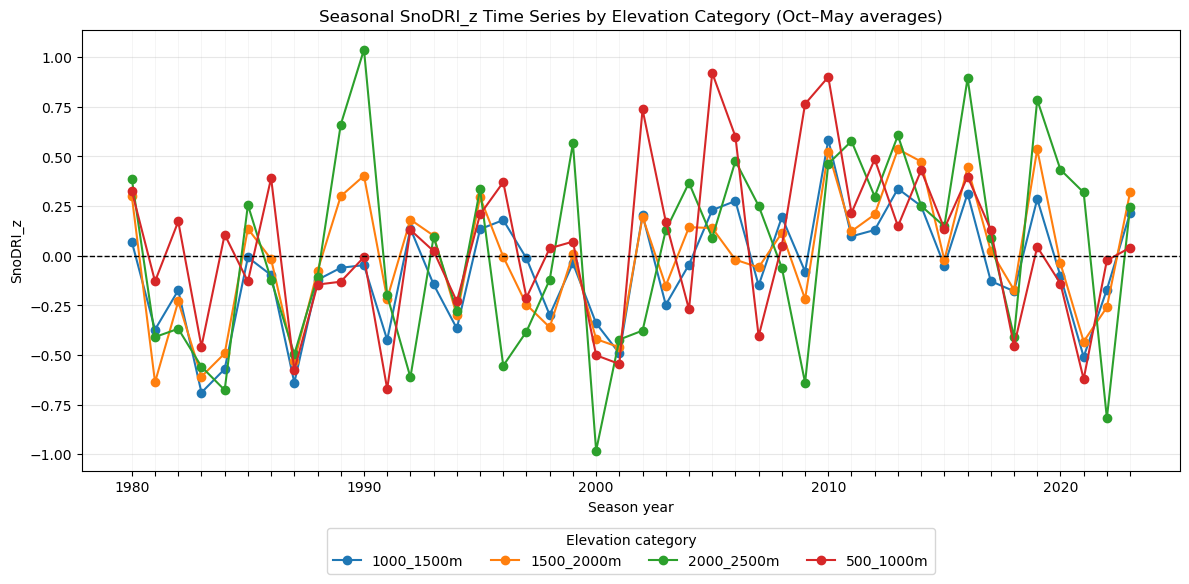

In [50]:
ts_df = seasonal_by_elevation_df.copy()  # uses variable from notebook

# pivot to wide format: index=season_year, columns=Elevation_Category, values=SnoDRI_z
ts_wide = ts_df.pivot(index='season_year', columns='Elevation_Category', values='SnoDRI_z').sort_index()

# ensure plots folder exists and define output path
plot_dir = Path(config['plots'])
plot_dir.mkdir(parents=True, exist_ok=True)
out_path = plot_dir / 'SnoDRI_z_timeseries.png'

plt.figure(figsize=(12, 6))
for col in ts_wide.columns:
    plt.plot(ts_wide.index, ts_wide[col], marker='o', linewidth=1.5, label=col)

plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.xlabel('Season year')
plt.ylabel('SnoDRI_z')
plt.title('Seasonal SnoDRI_z Time Series by Elevation Category (Oct–May averages)')
ax = plt.gca()
# show gridlines for each year (major ticks set to every season_year)
ax.set_xticks(ts_wide.index)
ax.grid(which='major', axis='x', color='lightgray', linestyle='-', linewidth=0.5)

# only show labels for selected years
show_years = {1980, 1990, 2000, 2010, 2020}
ax.set_xticklabels([str(y) if y in show_years else '' for y in ts_wide.index])

# place legend at the bottom in one line
plt.legend(title='Elevation category', loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=len(ts_wide.columns))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(out_path, dpi=150)
print(f"Saved figure to {out_path}")
plt.show()